# PM2.5 prediction

### Import libraries

In [25]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
from scipy.stats import stats
seed(1)
import geopandas as gpd
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Data Import

In [26]:
TARGET = 'pm25_st'
NUMBER_OF_PARAMS = 6
data = gpd.read_file('grids/'+ 'grid_cams_0418_0425_2021.gpkg')


data = data[~data[TARGET].isnull()]
data = data.dropna(axis=1)


data.pop('geometry')
data.pop('bottom')
data.pop('top')
data.pop('left')
data.pop('right')

labels = pd.read_csv('results/grid_cams_0418_0425_2021.csv').iloc[:NUMBER_OF_PARAMS]

#read variables which are not null
score_results = pd.DataFrame()

#Store dataset in x and y variables
X = pd.DataFrame(data=data, columns=data.columns.tolist() )
Y = X[TARGET]
Y = Y.values.ravel()
X.pop(TARGET)
X.pop('lat_cen')
X.pop('lng_cen')
X = pd.DataFrame(data=X, columns=labels['Features']).dropna(axis=1)


In [27]:

NUMBER_OF_PARAMS = X.shape[1]
y1 = np.array(Y)

X_train, X_val, y_train, y_val = train_test_split(X, y1)

y_train=np.reshape(y_train, (-1,1))
y_val=np.reshape(y_val, (-1,1))

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_x.fit(X_train)
xtrain_scale=scaler_x.transform(X_train)
scaler_x.fit(X_val)
xval_scale=scaler_x.transform(X_val)

scaler_y.fit(y_train)
ytrain_scale=scaler_y.transform(y_train)
scaler_y.fit(y_val)
yval_scale=scaler_y.transform(y_val)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 7)                 49        
_________________________________________________________________
dense_19 (Dense)             (None, 224)               1792      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 225       
Total params: 2,066
Trainable params: 2,066
Non-trainable params: 0
_________________________________________________________________
Train on 16 samples, validate on 5 samples
Epoch 1/30
16/16 [==============================] - 1s 51ms/sample - loss: 0.1535 - mse: 0.1535 - mae: 0.3142 - val_loss: 0.0743 - val_mse: 0.0743 - val_mae: 0.2204
Epoch 2/30
16/16 [==============================] - 0s 4ms/sample - loss: 0.0623 - mse: 0.0623 - mae: 0.2065 - val_loss: 0.0256 - val_mse: 0.0256

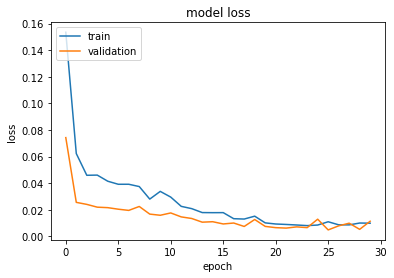

Values predicted:  [[18.320013]
 [21.652878]
 [21.000748]
 [21.212547]
 [19.958696]
 [19.085114]
 [19.887175]]
Values :  [[17.625     ]
 [24.625     ]
 [22.375     ]
 [22.625     ]
 [22.16666667]
 [19.        ]
 [19.75      ]]
Mean Absolute Error:  1.269156955537342
Mean Squared Error:  2.5859056511167546
Mean (Y-test): 21.166666666666668
Mean (Y-predicted):  20.159595
R2 score:  0.49425826613781754


In [28]:
from sklearn.metrics import r2_score

model = Sequential()
model.add(Dense(NUMBER_OF_PARAMS+1, input_dim=NUMBER_OF_PARAMS, kernel_initializer='normal', activation='relu'))
model.add(Dense(X.shape[0]*(NUMBER_OF_PARAMS+2), activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history=model.fit(xtrain_scale, ytrain_scale, epochs=30, batch_size=1, verbose=1, validation_split=0.2)
predictions = model.predict(xval_scale)

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

predictions = scaler_y.inverse_transform(predictions)


print('Values predicted: ', predictions)
print('Values : ', scaler_y.inverse_transform(yval_scale))

print('Mean Absolute Error: ',mean_absolute_error(y_val, predictions))
print('Mean Squared Error: ',mean_squared_error(y_val, predictions))
print('Mean (Y-test):',np.mean(y_val))
print('Mean (Y-predicted): ',np.mean(predictions))
print('R2 score: ',r2_score(y_val, predictions))